<a href="https://colab.research.google.com/github/rimosoma/neural/blob/main/Lab3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**MACHINE LEARNING AND NEURAL NETWORKS, A.A. 2025/2026**

**COMPUTER LAB 3** - Principal component analysis

**Duration: 3 hours**

**Introduction:**

Hyperspectral images are images of the Earth acquired by satellites or aicrafts. Rather than having three R/G/B color channels, these images have a lot more “color” components obtained through a fine sampling of the wavelength spectrum (hence the name “hyper”-spectral). The
resulting 3-dimensional dataset has one image (spectral band or “color”) for every sampled wavelength, which represents the measured radiance from each pixel at that specific wavelength. Hyperspectral images are very useful for image analysis: for every pixel at a given spatial position, it is possible to extract a so-called spectral vector, i.e. the 1-dimensional vector of values assumed by that pixel at all wavelengths. Assuming that each pixel is composed of just one substance, the spectral vector represents the radiance of that substance at all the wavelengths that have been
sampled. Therefore, spectral vectors can be used to infer which substance is contained in a given pixel (this is a typical classification problem that has a lot of practical applications in agriculture, analysis of land use / land cover, and other applications related to the study of the environment).


In this lab you will use a real hyperspectral image that has been acquired by the AVIRIS instrument, an airborne hyperspectral imager operated by the NASA. The image represents a scene of Indian Pines (Indiana, USA). It has a size of 145x145 pixels and 220 spectral bands. Along with the image, a ground truth is available in terms of labels specifying which class (out of 16) each pixel belongs to. The classes are reported below; for more information, please see
http://www.ehu.eus/ccwintco/index.php/Hyperspectral_Remote_Sensing_Scenes#Indian_Pines

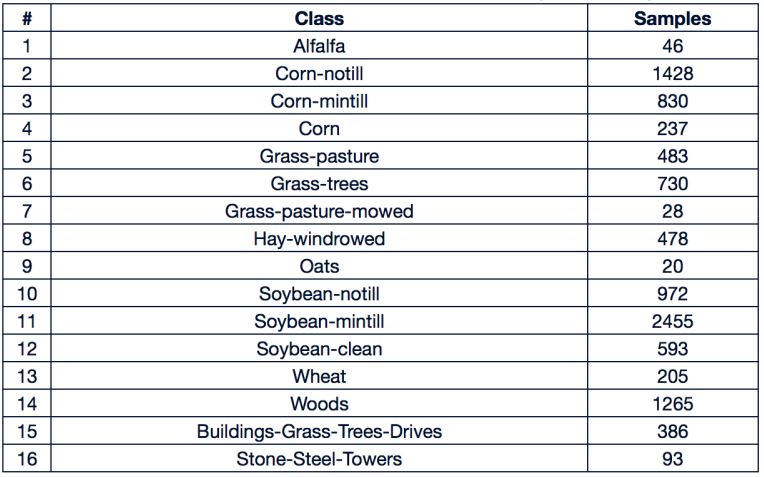

The purpose of this computer lab is twofold:
To apply PCA to the spectral vectors in order to reduce their dimensionality.

*   To apply PCA to the spectral vectors in order to reduce their dimensionality.
*   To perform classification on the reduced data (optional)

**Exercise 1 – PCA**


In this exercise, you will employ the Indian Pines dataset. You will not do this for the entire dataset, but only for the spectral vectors belonging to **two classes** (Note: also in the optional exercise you will perform 2-class classification on the PCA coefficients).

**Reminder:** the input to the PCA must always have zero mean: besides the sample covariance, you will have to compute the **mean value μ** over the training set and subtract it from each test vector before applying PCA.

**Task:** You have to reduce the dimensionality of the spectral vectors of the two classes you have chosen using PCA. In particular, you should perform the following:


*   Extract spectral vectors of two classes, as described above (see sample code below).
*   Estimate the sample covariance matrix of the dataset as a whole (i.e., considering together spectral vectors of the two classes)
*   Perform the eigenvector decomposition of the sample covariance matrix. You can use the numpy linalg.eig function, which outputs the matrix containing the eigenvectors as columns, and a diagonal matric containing the eigenvalues on the main diagonal.
  * Note: in the output matrix, eigenvectors/eigenvalues are not necessarily ordered by eigenvalue magnitude. You should sort them by yourself.
*   Choose a number of dimensions K<=220.
*   Construct the eigenvector matrix W for K components (i.e., select the last K columns)
*   Using W, compute the PCA coefficients for each spectral vector in the data set
*   Then from the PCA coefficients obtain an approximation of the corresponding vector and compute the error (mean square error - MSE)
*   Plot the average MSE over the test set as a function of K.
*   Plot the eigenvectors corresponding to the 3 largest eigenvalues – this will give you an idea of the basis functions employed by PCA

In [15]:
import numpy as np
import h5py
import scipy.io

#Prima di tutto salvo in un np.array i dati contenuti nel Indian_pines.mat,
#ovvero i dati veri e propri: per ciascun pixel sono contenute 220 features
#corrispondenti alle 220 spectral bands(immaginare un sudoku in cui, in ogni
#posizione(pixe) è presente un array di 220 dimensioni che descrive quel pixel)
mat = scipy.io.loadmat('Indian_pines.mat')
indian_pines = np.array(mat['indian_pines'])

#poi estraggo in un altro np.array i dati contenuti nel Indian_pines_gt.mat,
#ovvero i dati ground truth: per ogni pixel è memorizzato solo 1 numero: la
#vera classe di appartenenza(immaginare un sudoku piatto)
mat = scipy.io.loadmat('Indian_pines_gt.mat')
indian_pines_gt = np.array(mat['indian_pines_gt'])


**Extract spectral vectors of two classes, as described above (see sample code below).**

In [16]:
class0_value = 2
#NumPy: "Preparami un grande contenitore vuoto (una scatola) da 3000 posti.
#Non so quanti me ne serviranno, ma di sicuro meno di 3000. Man mano che trovo
#i pixel giusti, li metterò in questa scatola, uno dopo l'altro, partendo dal
#posto n=0, e ogni pixel dovrà contenere l'informazione di 220 spettri
#(il prof aveva inizializzato a 1500 ma ci sono classi con + di 1500 pixel)
class0=np.zeros((3000,220))
n=0
#ciclo su ogni pixel dell'immagine
for i in range(145):
  for j in range(145):
    #se il pixel appartiene alla classe desiderata(verifico con indian_pines_gt)
    if indian_pines_gt[i,j]== class0_value:
      #inserisco il pixel nella posizione n-esima della scatola creata inizialmente
      #prendendo i 220 spettri dal indian_pines sfruttando la stessa posizione
      #(indicizzazione) del pixel nei due files
      #questa notazione infatti dice: "sulla riga n della scatola, usa tutte
      #le colonne (220)inserendo cio che è contenuto all'indice i,j di i
      #ndian_pines, che sarà un array proprio di 220 dimensioni"
      class0[n,:] = indian_pines[i,j,:]/1.
      n=n+1
#quest'ultimo comando serve a tagliare la scatola iniziale secondo lo spazio
#effettivamente usato
class0=class0[:n,:]



#ripeto tutto quanto per un'altra classe, ottenendo la seconda matrice(scatola),

class1_value = 11

class1=np.zeros((3000,220))
n=0
for i in range(145):
  for j in range(145):
    if indian_pines_gt[i,j]== class1_value:
      class1[n,:] = indian_pines[i,j,:]/1.
      n=n+1
class1=class1[:n,:]

**Estimate the sample covariance matrix of the dataset as a whole (i.e., considering together spectral vectors of the two classes)**

In [17]:
#Unisco le 2 matrici ottenendo quindi un elenco di righe da 220 dimensioni
#in cui sono elencate gli spettri di tutti i pixel appartenenti alle 2 classi
X_two_classes = np.concatenate((class0, class1), axis=0)

#RICHIESTO
#(sottrarre la media): Perché la PCA cerca le direzioni di
#massima varianza, e la varianza è definita attorno alla media.
#Senza centratura, il primo asse che la PCA troverebbe non sarebbe la
#direzione di massima varianza, ma semplicemente la direzione in cui i
#dati sono "lontani" dall'origine (0,0).

#NON RICHIESTO
#(dividere per st. dev.): Perché la PCA è "sensibile" alla scala.
# Se una banda (feature) ha valori molto grandi (es. 0-10000) e
#un'altra ha valori piccoli (es. 0-1), la PCA si concentrerà solo sulla prima,
#ignorando l'informazione della seconda. Normalizzando, tutte le bande sono
#"sullo stesso piano" e dai a tutte la stessa importanza iniziale.

mu = np.mean(X_two_classes, axis=0)
std = np.std(X_two_classes, axis=0)

X_centered = X_two_classes - mu
X_normalized = X_centered / std


#calcolo la matrice di covarianza della centrata o normalizzata:
covariance_matrix_centr = np.cov(X_centered.T)
covariance_matrix_norm = np.cov(X_normalized.T)

**Perform the eigenvector decomposition of the sample covariance matrix. You can use the numpy linalg.eig function, which outputs the matrix containing the eigenvectors as columns, and a diagonal matric containing the eigenvalues on the main diagonal.**

In [18]:
from numpy import linalg as LA

vettore_1D_autovalori, lista_autovettori = LA.eig(covariance_matrix_centr)

#Note: in the output matrix, eigenvectors/eigenvalues are not necessarily
#ordered by eigenvalue magnitude. You should sort them first.

#Nella PCA infatti si vuole:
#Ordinamento: Trovare gli autovalori (che sono numeri) e ordinarli dal più
  #grande al più piccolo.
#Riferimento: Si usa quest'ordine per "riordinare" gli
  # autovettori (che sono vettori). L'autovettore che corrispondeva all'autovalore
  #più grande diventa la tua prima colonna di W, e così via.
#Costruzione di W: La matrice W è costruita solo con gli autovettori (che sono
  #le "nuove direzioni"). L'autovalore è servito solo per sapere quali
  #autovettori erano i più importanti (quelli che "spiegano" più varianza).

#ordino quindi gli autovettori usando come parametro i corrispondenti autovalori,
#sfruttando argsort che mi restituisce le posizioni:
autovet_ord = lista_autovettori[:, vettore_1D_autovalori.argsort()[::-1]]

#autovet_ord è quindi semplicemente la matrice intera contenente come colonne
#tutti gli autovettori, non resta che spezzarla ad L colonne per ottenere W


#PROCESSO PARALLELO PER I DATI NORMALIZZATI
vettore_1D_autovalori_norm, lista_autovettori_norm = LA.eig(covariance_matrix_norm)
autovet_ord_norm = lista_autovettori_norm[:, vettore_1D_autovalori_norm.argsort()[::-1]]


**Choose a number of dimensions K<=220.Construct the eigenvector  matrix W for K components (i.e., select the last K columns)**

In [22]:
#Qui devo scegliere il numero K di dimensioni a cui voglio ridurre i pixel dalle
# 220 dimensioni iniziali ma poiche dopo viene richiesto di effettuare un plot
#in funzione di K, forse conviene creare una funzione richiamabile che lavora
#sulla matrice completa degli autovettori e estrae le prime k colonne

def extracting_W(k):
  return autovet_ord[:, :k]


def extracting_W_norm(k):
  return autovet_ord_norm[:, :k]

**Using W, compute the PCA coefficients for each spectral vector in the data set. Then from the PCA coefficients obtain an approximation of the corresponding vector and compute the error (mean square error - MSE)**

In [24]:
#Note: remember to remove the mean from the vectors of the dataset

import matplotlib.pyplot as plt

# --- Preparazione del Ciclo ---
K_values = np.arange(1, 221)  # Cicliamo per K da 1 a 220
mse_errors = [] # Lista per salvare l'errore ad ogni K
mse_errors_norm = []


print("Inizio ciclo per K da 1 a 220...")

# --- Esecuzione del Ciclo, cioè pr ogni valore di k calcolo la W corrispondente
# e determino la proiezione Z e la xhat ricostruita partendo dallo spazio a meno
#dimensioni, calcolando poi la differenza rispetto al valore originale ---
for K in K_values:

    # Ottieni la matrice W per il K corrente
    W_K = extracting_W(K)
    W_K_norm = extracting_W_norm(K)

    #  Calcolo dei Coefficienti PCA (Proiezione)
    Z_coeff = X_centered @ W_K
    Z_coeff_norm = X_normalized @ W_K_norm

    # Ricostruzione del Vettore (Approssimazione)
    X_hat = Z_coeff @ W_K.T
    X_hat_norm = Z_coeff_norm @ W_K_norm.T

    # Calcolo dell'Errore (MSE)
    mse = np.mean((X_centered - X_hat)**2)
    mse_norm = np.mean((X_normalized - X_hat_norm)**2)
    # Salva l'errore per questo K
    mse_errors.append(mse)
    mse_errors_norm.append(mse_norm)

print("Ciclo completato.")



Inizio ciclo per K da 1 a 220...
Ciclo completato.


**Plot the average MSE over the test set as a function of K.**

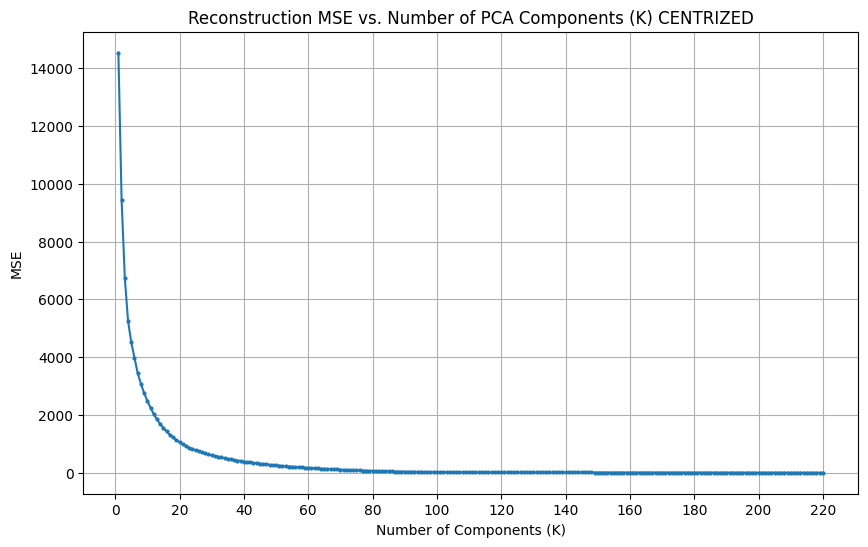

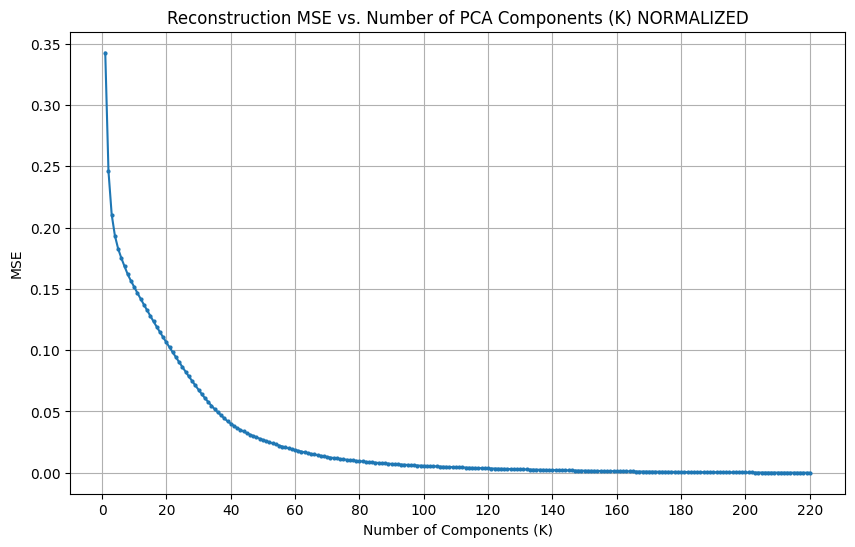

In [26]:
#  Risultato: Plot dell'MSE
# (Questo plot è il risultato del ciclo poichè associa l'errore corrispondente
#ai vari livelli di sottodimensionamento)
plt.figure(figsize=(10, 6))
plt.plot(K_values, mse_errors, marker='o', linestyle='-', markersize=2)
plt.title('Reconstruction MSE vs. Number of PCA Components (K) CENTRIZED')
plt.xlabel('Number of Components (K)')
plt.ylabel('MSE')
plt.grid(True)
plt.xticks(np.arange(0, 221, 20))
plt.show() # Mostra l'immagine

#plot dei dati normalizzati:
plt.figure(figsize=(10, 6))
plt.plot(K_values, mse_errors_norm, marker='o', linestyle='-', markersize=2)
plt.title('Reconstruction MSE vs. Number of PCA Components (K) NORMALIZED')
plt.xlabel('Number of Components (K)')
plt.ylabel('MSE')
plt.grid(True)
plt.xticks(np.arange(0, 221, 20))
plt.show() # Mostra l'immagine

**Plot the eigenvectors corresponding to the 3 largest eigenvalues – this will give you an idea of the basis functions employed by PCA**

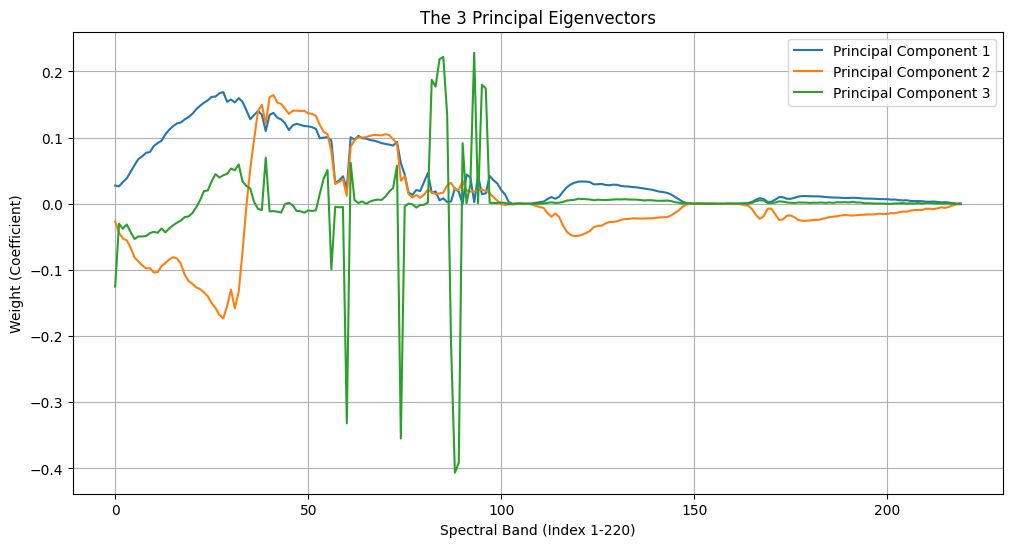

In [9]:
#  Plot dei 3 Autovettori Principali
plt.figure(figsize=(12, 6))

# Estrae la colonna 0 (Autovettore 1)
plt.plot(autovet_ord[:, 0], label='Principal Component 1')

# Estrae la colonna 1 (Autovettore 2)
plt.plot(autovet_ord[:, 1], label='Principal Component 2')

# Estrae la colonna 2 (Autovettore 3)
plt.plot(autovet_ord[:, 2], label='Principal Component 3')

plt.title('The 3 Principal Eigenvectors')
plt.xlabel('Spectral Band (Index 1-220)')
plt.ylabel('Weight (Coefficient)')
plt.legend()
plt.grid(True)
plt.show()


**Student's comments to Exercise 1**

The goal of Exercise 1 was to apply Principal Component Analysis (PCA) to analyze and reduce the dimensionality of the "Indian Pines" hyperspectral dataset (2 classes, 220 bands). PCA is a fundamental unsupervised feature extraction technique that transforms the data into a new system of uncorrelated axes (the Principal Components), ordered by amount of explained variance.

1. Procedure Rationale: Standardization (Z-score): The first critical step was standardizing the data (subtract the mean, divide by the standard deviation). Why? PCA is variance-driven. Hyperspectral data has bands with very different scales and variances (some "noisy," some "flat"). Without standardization, the bands with the highest numerical variance would dominate the analysis, regardless of their informational importance. Standardization ensures that each band contributes equally.

2. Covariance Eigendecomposition: We computed the covariance matrix on the standardized data. The eigendecomposition of this matrix gave us: Eigenvalues ​​($\Lambda$): The amount of variance (information) captured by each component. Eigenvectors ($\mathbf{W}$): The new axes (the Principal Components), which are the directions of maximum variance. Sorting: The eigenvectors were sorted by their eigenvalue (from largest to smallest). This is essential because it allows us to select the first $K$ components knowing that they are the most informative.

3. Analysis of Results (I Plots) The exercise produced two key graphs for the analysis:
- Plot 1: Mean Squared Error (MSE) vs. K This graph shows the average reconstruction error of the original data when using only the first $K$ components. For completeness I have generated 2 different plots, one with the PCA computed over centered data and the other with the PCA computed over normalized data. In the first (Centered Only)
the Y-axis (MSE) scale is massive, starting at over 14,000. This immediately indicates that the total variance in the dataset is huge and, more importantly, unevenly distributed. The curve drops extremely rapidly, with a very sharp "elbow" around K=20. After this point, the curve appears to flatten.
Because of that, this graph is misleading. It doesn't mean the data's useful information is captured in 20 components. Instead, it shows that the first 20 principal components are almost entirely dominated by the few original bands that had the highest numerical variance (the "loudest" bands). The PCA is effectively just modeling the scale of these few bands, while ignoring the valuable, correlated information in the lower-variance bands.
In the second plot(Normalized) the Y-axis is now in an interpretable range. Since every band was scaled to have a variance of 1, the maximum MSE of ~0.35 can be understood as a fraction of the average variance. The curve descends much more smoothly and gradually. There is no single "sharp" elbow. The MSE continues to decrease significantly all the way past K=150. This plot reveals the true intrinsic dimensionality of the data. By giving every band an equal footing (variance=1), the PCA is no longer modeling scale; it is now properly modeling the correlation structure between the bands. This graph correctly shows that the useful information is distributed across many components, not just a handful.


- Plot 2: First 3 Eigenvectors (Basic Functions)This plot shows the first 3 columns of the matrix $\mathbf{W}$ (the 3 eigenvectors with the largest eigenvalues). These are no longer "bands", but synthetic "spectral signatures" that PCA has identified as the most important ones.Result:PC1 (Component 1): Has positive weights (coefficients) on almost all 220 bands.PC2 (Component 2): Shows a strong contrast (positive vs. negative weights) between the low-wavelength and high-wavelength (infrared) bands.Rationale: PCA has "learned" the fundamental structures of variance.PC1 represents the "average spectral signature" or overall radiance trend.PC2 (and subsequent components) capture the main sources of variation or contrast in the data (e.g., the contrast between vegetation and soil, or between the two chosen crop types).In Exercise 2, we will use these $K$ new "features" (the PCA coefficients) to train the classifiers.

**Exercise 2 – Classification using dimensionality reduction and whitening (optional)**

In this exercise you will apply a simple 2-class linear discriminant analysis (LDA) classifier to the data belonging to the two classes, before and after **whitening** (i.e. applying PCA plus rescaling
each coefficient to unit variance: $y = \Lambda^{-\frac{1}{2}}W^{T}x$. Note that matrix $\Lambda$ is obtained as one of the outputs of *eig.m*). This classifier makes the Naïve Bayes Classifier assumption that the features are statistically independent, thus the shared covariance matrix is taken as $\Sigma = I$. We also assume that class 0 and class 1 are equiprobable. Thus, letting $\mu_{0}$ and $\mu_{1}$ be the mean of vectors in class 0 and 1, we define $x_{0} = 0.5(\mu_{0} + \mu_{1})$ and $w = \mu_{1}-\mu_{0}$. A test vector $x$ is classified into class 1 or 0 depending on whether $sign(w^{T}(x − x_{0}))$ is equal to +1 or -1.

When the classifier is applied to the PCA coefficients, you can simply replace $\mu_{0}$ and $\mu_{1}$ with their reduced versions (subtracting $\mu$ and applying the same PCA matrix computed over the training set), and recalculate $x_{0}$ and $w$ accordingly.

**Task:** Divide the Indian Pines dataset into training and test sets (e.g. 75% of the data of each class to be used as training data, and 25% as test data). Train this classifier on the training data, and
apply it to the test data. In particular, you should perform the following:
*   Plot the mean vector of class 0 and 1 – this will give you a visual description of the differences among vectors of either class.
*   Apply the classifier to the original data (without PCA) and compute its accuracy
*   Apply the classifier to the PCA coefficients for different values of K, and compute its accuracy
*   Apply the classifier to the original data where only the first K features have been retained, and compute its accuracy (this is a more brutal way to reduce dimensionality)
*   Try to classify the data using a Support Vector Machine and compare the results





**Plot the mean vector of class 0 and 1 – this will give you a visual description of the differences among vectors of either class.**

Caricamento file .mat...
Dati Classe 2: (1428, 220)
Dati Classe 11: (2455, 220)
Dimensioni X_train_raw: (2912, 220)
Dimensioni y_train: (2912,)
Dimensioni X_test_raw: (971, 220)
Dimensioni y_test: (971,)
Plot 'mean_vectors_std_plot.png' generato.


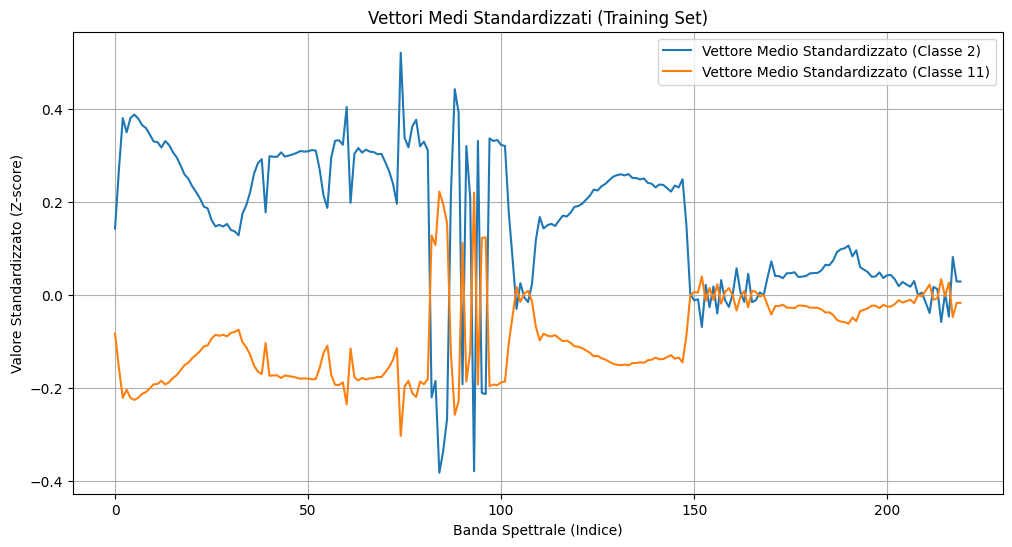

In [ ]:
import numpy as np
import scipy.io
from sklearn.model_selection import train_test_split

# --- 1. Caricamento Dati ---
print("Caricamento file .mat...")
class0_value = 2
class0=np.zeros((3000,220))
n=0
for i in range(145):
  for j in range(145):
    if indian_pines_gt[i,j]== class0_value:
      class0[n,:] = indian_pines[i,j,:]/1.
      n=n+1
class0_data=class0[:n,:]



class1_value = 11

class1=np.zeros((3000,220))
n=0
for i in range(145):
  for j in range(145):
    if indian_pines_gt[i,j]== class1_value:
      class1[n,:] = indian_pines[i,j,:]/1.
      n=n+1
class1_data=class1[:n,:]

print(f"Dati Classe {class0_value}: {class0_data.shape}")
print(f"Dati Classe {class1_value}: {class1_data.shape}")

# --- 3. Divisione Train (75%) / Test (25%) ---
# È importante dividere le classi *separatamente* per mantenere
# la proporzione 75/25 per *entrambe* le classi.

# Dividi la Classe 0
c0_train, c0_test = train_test_split(class0_data, test_size=0.25, random_state=42)
# Dividi la Classe 1
c1_train, c1_test = train_test_split(class1_data, test_size=0.25, random_state=42)

# Unisci i dati di addestramento
# np.vstack impila verticalmente gli array
X_train_raw = np.concatenate((c0_train, c1_train), axis=0)
# Assegna le etichette al training set. Poiché X_train_raw è stato costruito
# prima con i pixel di c0_train e poi con quelli di c1_train,
# la lista di etichette deve seguire lo stesso ordine: [0, 0, ..., 1, 1, ..,1]
y_train = np.array([0] * len(c0_train) + [1] * len(c1_train))

# Unisci i dati di test
X_test_raw = np.concatenate((c0_test, c1_test), axis=0)
# Crea le etichette di test(come per il train)
y_test = np.array([0] * len(c0_test) + [1] * len(c1_test))

print(f"Dimensioni X_train_raw: {X_train_raw.shape}")
print(f"Dimensioni y_train: {y_train.shape}")
print(f"Dimensioni X_test_raw: {X_test_raw.shape}")
print(f"Dimensioni y_test: {y_test.shape}")

# --- 4. Standardizzazione (Centratura + Normalizzazione) ---
# Calcola media e std dev SOLO SUI DATI DI TRAINING
mu_train = np.mean(X_train_raw, axis=0)
std_train = np.std(X_train_raw, axis=0)
# Evita divisione per zero se una banda è costante
std_train[std_train == 0] = 1.0

# Applica la standardizzazione (calcolata sul train) a entrambi i set
X_train_std = (X_train_raw - mu_train) / std_train
X_test_std = (X_test_raw - mu_train) / std_train



# --- Task 1: Plot dei Vettori Medi (Standardizzati) ---
# Calcoliamo le medie SUI DATI STANDARDIZZATI DI TRAINING
# (Questi ci serviranno per tutti i task successivi)
#Questo vettore medio, noto anche come vettore centroide della classe, viene
#utilizzato in vari algoritmi di classificazione, in particolare quelli basati
#sulla distanza come il classificatore

#Nel contesto dell'esercizio (LDA Semplificato)
#che stai eseguendo, il vettore medio è cruciale per definire:
#Il Vettore Direzione w: La differenza tra i due vettori medi
#standardizzati, w = mu1 - mu0, definisce la
#direzione ottimale per separare le due classi. Questa direzione w è
#quella che massimizza la separazione tra le medie delle due classi.
#Il Punto di Decisone x_0: La media delle due medie, x_0 = 0.5(mu0 + mu1),
#stabilisce il punto centrale tra i due prototipi di classe.La Regola di Classificazione:
# Un nuovo campione x viene classificato proiettandolo su questa direzione w
#e vedendo se si trova più vicino a mu1 o a mu0 rispetto al punto medio x0.

mu_0_std = np.mean(X_train_std[y_train == 0], axis=0)
mu_1_std = np.mean(X_train_std[y_train == 1], axis=0)

plt.figure(figsize=(12, 6))
plt.plot(mu_0_std, label=f'Vettore Medio Standardizzato (Classe {class0_value})')
plt.plot(mu_1_std, label=f'Vettore Medio Standardizzato (Classe {class1_value})')
plt.title('Vettori Medi Standardizzati (Training Set)')
plt.xlabel('Banda Spettrale (Indice)')
plt.ylabel('Valore Standardizzato (Z-score)')
plt.legend()
plt.grid(True)
plt.savefig('mean_vectors_std_plot.png')
# plt.show() # In un notebook, al posto di savefig
print("Plot 'mean_vectors_std_plot.png' generato.")


**Apply the classifier to the original data (without PCA) and compute

its accuracy**

In [ ]:
#For this section you can use the code you developed for the previous Lab or the sklearn function LinearDiscriminantAnalysis

from sklearn.metrics import accuracy_score

# --- Task 2: Classificatore LDA Semplificato (Sigma=I) ---
# Usiamo le medie standardizzate calcolate nel Blocco 2 (mu_0_std, mu_1_std)
#
# Le istruzioni dicono:
# w = mu_1 - mu_0
# x0 = 0.5 * (mu_0 + mu_1)
# Classifica = sign(w^T * (x - x_0))

w_simple = mu_1_std - mu_0_std
x_0_simple = 0.5 * (mu_0_std + mu_1_std)

# Applichiamo al Test Set (X_test_std)
# Calcoliamo (x - x_0) per tutti i campioni
X_test_centered = X_test_std - x_0_simple

# Calcoliamo lo score (prodotto scalare)
# (N_test, 220) @ (220,) -> (N_test,)
scores_simple = X_test_centered @ w_simple

# Predici classe 1 (True) se score > 0, altrimenti classe 0 (False)
y_pred_lda_simple = (scores_simple > 0).astype(int)

# Calcola accuratezza
accuracy_lda_simple = accuracy_score(y_test, y_pred_lda_simple)
print(f"--- Task 2: Accuratezza LDA Semplificato (su dati standardizzati) ---")
print(f"Accuratezza: {accuracy_lda_simple * 100:.2f}%")

--- Task 2: Accuratezza LDA Semplificato (su dati standardizzati) ---
Accuratezza: 63.13%


**Apply the classifier to the PCA coefficients for different values of K, and compute its accuracy**

Calcolo PCA sul training set...
Inizio ciclo LDA per K (PCA Whitened)...
Ciclo completato.
Plot 'accuracy_vs_K_pca.png' generato.


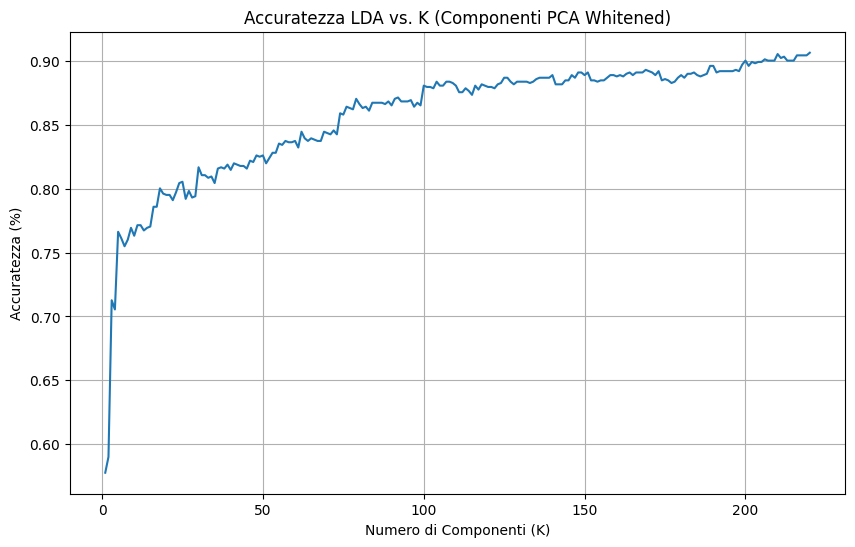

In [ ]:
from numpy import linalg as LA

# --- Task 3: Classificatore su PCA "Whitened" ---

# 1. Calcola PCA (come da Esercizio 1, ma SUL TRAINING SET)
print("Calcolo PCA sul training set...")
cov_matrix_train = np.cov(X_train_std, rowvar=False)
w_eigvals, v_eigvecs = LA.eig(cov_matrix_train)

# Ordina autovettori e autovalori
sorted_indices = np.argsort(w_eigvals)[::-1]
w_eigvals_sorted = w_eigvals[sorted_indices]
v_eigvecs_sorted = v_eigvecs[:, sorted_indices] # Matrice W_total (220x220)

# 2. Ciclo su K per calcolare accuratezza
K_values = np.arange(1, 221)
accuracies_pca = []

print("Inizio ciclo LDA per K (PCA Whitened)...")
for K in K_values:
    # Matrice W_K (220 x K)
    W_K = v_eigvecs_sorted[:, :K]

    # Autovalori per whitening (Lambda^-1/2)
    lambda_K = w_eigvals_sorted[:K]
    # Evita divisione per zero con .clip()
    lambda_K_inv_sqrt = 1.0 / np.sqrt(np.clip(lambda_K, 1e-10, None))

    # --- Trasformazione Dati (Train e Test) ---
    # Proiezione PCA (Z = X_std * W_K)
    Z_train = X_train_std @ W_K
    Z_test = X_test_std @ W_K

    # Whitening (Y = Z * Lambda^-1/2)
    Y_train = Z_train * lambda_K_inv_sqrt
    Y_test = Z_test * lambda_K_inv_sqrt

    # --- Trasformazione Medie (Train) ---
    # Proiettiamo e sbianchiamo anche le medie calcolate nel Blocco 2
    Z_mu_0_std = mu_0_std @ W_K
    Z_mu_1_std = mu_1_std @ W_K

    Y_mu_0 = Z_mu_0_std * lambda_K_inv_sqrt
    Y_mu_1 = Z_mu_1_std * lambda_K_inv_sqrt

    # --- Classificatore LDA Semplificato nello spazio "Whitened" (Y) ---
    # Nello spazio Y, la covarianza è I, quindi il modello si applica perfettamente.
    w_pca = Y_mu_1 - Y_mu_0
    x_0_pca = 0.5 * (Y_mu_0 + Y_mu_1)

    Y_test_centered = Y_test - x_0_pca
    scores_pca = Y_test_centered @ w_pca

    y_pred_pca = (scores_pca > 0).astype(int)
    acc_pca_K = accuracy_score(y_test, y_pred_pca)
    accuracies_pca.append(acc_pca_K)

print("Ciclo completato.")

# --- Plot Accuratezza vs K (PCA) ---
plt.figure(figsize=(10, 6))
plt.plot(K_values, accuracies_pca, label='LDA su PCA "Whitened"')
plt.title('Accuratezza LDA vs. K (Componenti PCA Whitened)')
plt.xlabel('Numero di Componenti (K)')
plt.ylabel('Accuratezza (%)')
plt.grid(True)
plt.savefig('accuracy_vs_K_pca.png')
# plt.show()
print("Plot 'accuracy_vs_K_pca.png' generato.")

**Apply the classifier to the original data where only a subset of K features (selected randomly) have been retained, and compute its accuracy (this is a more brutal way to reduce dimensionality)**

Inizio ciclo LDA per K (Prime K Features)...
Ciclo completato.
Plot 'accuracy_comparison_pca_vs_brute.png' generato.


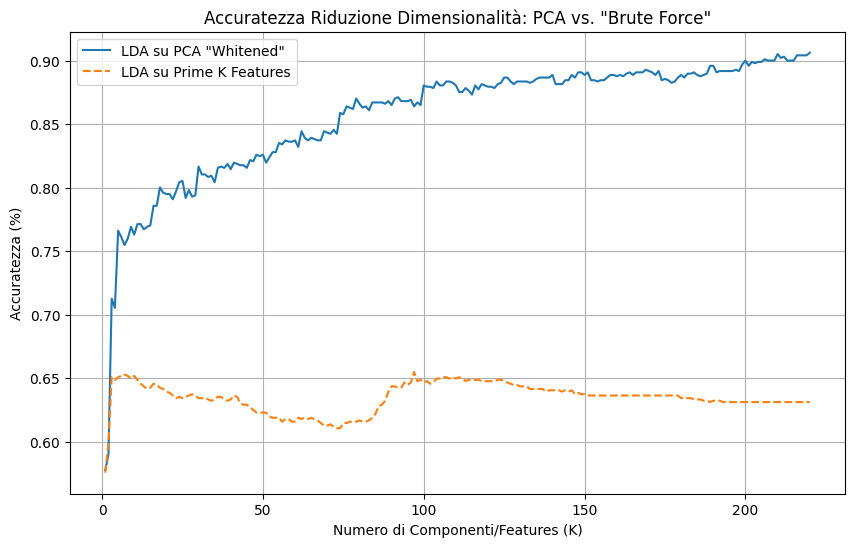

In [ ]:
# --- Task 4: Classificatore su K feature "brutali" (prime K) ---
# (K_values e accuracies_pca devono essere in memoria dal Blocco 4)

print("Inizio ciclo LDA per K (Prime K Features)...")
accuracies_brute = []

for K in K_values: # K_values è np.arange(1, 221)
    # Seleziona le prime K features
    X_train_brute = X_train_std[:, :K]
    X_test_brute = X_test_std[:, :K]

    # Medie ridotte (calcolate nel Blocco 2)
    mu_0_brute = mu_0_std[:K]
    mu_1_brute = mu_1_std[:K]

    # Classificatore LDA Semplificato
    w_brute = mu_1_brute - mu_0_brute
    x_0_brute = 0.5 * (mu_0_brute + mu_1_brute)

    X_test_centered_brute = X_test_brute - x_0_brute
    scores_brute = X_test_centered_brute @ w_brute

    y_pred_brute = (scores_brute > 0).astype(int)
    acc_brute_K = accuracy_score(y_test, y_pred_brute)
    accuracies_brute.append(acc_brute_K)

print("Ciclo completato.")

# --- Plot di Confronto (PCA vs Brute) ---
plt.figure(figsize=(10, 6))
plt.plot(K_values, accuracies_pca, label='LDA su PCA "Whitened"')
plt.plot(K_values, accuracies_brute, label='LDA su Prime K Features', linestyle='--')
plt.title('Accuratezza Riduzione Dimensionalità: PCA vs. "Brute Force"')
plt.xlabel('Numero di Componenti/Features (K)')
plt.ylabel('Accuratezza (%)')
plt.grid(True)
plt.legend()
plt.savefig('accuracy_comparison_pca_vs_brute.png')
# plt.show()
print("Plot 'accuracy_comparison_pca_vs_brute.png' generato.")

**Try to classify the data using a Support Vector Machine and compare the results**

In [ ]:
from sklearn.svm import SVC

# --- Task 5: Classificazione con Support Vector Machine (SVM) ---

print("\n--- Confronto con SVM ---")

# 1. SVM su Dati Originali (Standardizzati)
print("Training SVM (Lineare) su dati standardizzati (220 features)...")
svm_linear = SVC(kernel='linear')
svm_linear.fit(X_train_std, y_train)
y_pred_svm_linear = svm_linear.predict(X_test_std)
acc_svm_linear = accuracy_score(y_test, y_pred_svm_linear)
print(f"Accuratezza SVM (Lineare) su Dati Originali: {acc_svm_linear * 100:.2f}%")

# 2. SVM su Dati PCA (usando K=36, come trovato nell'Esercizio 1)
K_best = 36 # Basato sulla nostra analisi precedente (95% varianza)

# (v_eigvecs_sorted deve essere in memoria dal Blocco 4)
W_K_best = v_eigvecs_sorted[:, :K_best]

# Usiamo i coefficienti Z (PCA non-whitened) per SVM
Z_train_best = X_train_std @ W_K_best
Z_test_best = X_test_std @ W_K_best

print(f"Training SVM (Lineare) su dati PCA (K={K_best})...")
svm_linear_pca = SVC(kernel='linear')
svm_linear_pca.fit(Z_train_best, y_train)
y_pred_svm_linear_pca = svm_linear_pca.predict(Z_test_best)
acc_svm_linear_pca = accuracy_score(y_test, y_pred_svm_linear_pca)
print(f"Accuratezza SVM (Lineare) su Dati PCA (K={K_best}): {acc_svm_linear_pca * 100:.2f}%")

# 3. SVM (RBF) su Dati PCA (più potente)
print(f"Training SVM (RBF) su dati PCA (K={K_best})...")
svm_rbf_pca = SVC(kernel='rbf') # RBF (Gaussiano) è il default
svm_rbf_pca.fit(Z_train_best, y_train)
y_pred_svm_rbf_pca = svm_rbf_pca.predict(Z_test_best)
acc_svm_rbf_pca = accuracy_score(y_test, y_pred_svm_rbf_pca)
print(f"Accuratezza SVM (RBF) su Dati PCA (K={K_best}): {acc_svm_rbf_pca * 100:.2f}%")

# --- Riepilogo Finale ---
print("\n--- Riepilogo Accuratezze Test Set ---")
print(f"LDA Semplificato (Originale): {accuracy_lda_simple * 100:.2f}%")
print(f"LDA Semplificato (PCA Whitened, K={np.argmax(accuracies_pca)+1}): {np.max(accuracies_pca) * 100:.2f}%")
print(f"LDA Semplificato (Prime K Features, K={np.argmax(accuracies_brute)+1}): {np.max(accuracies_brute) * 100:.2f}%")
print(f"SVM Lineare (Originale): {acc_svm_linear * 100:.2f}%")
print(f"SVM Lineare (PCA, K={K_best}): {acc_svm_linear_pca * 100:.2f}%")
print(f"SVM RBF (PCA, K={K_best}): {acc_svm_rbf_pca * 100:.2f}%")


--- Confronto con SVM ---
Training SVM (Lineare) su dati standardizzati (220 features)...
Accuratezza SVM (Lineare) su Dati Originali: 90.32%
Training SVM (Lineare) su dati PCA (K=36)...
Accuratezza SVM (Lineare) su Dati PCA (K=36): 82.18%
Training SVM (RBF) su dati PCA (K=36)...
Accuratezza SVM (RBF) su Dati PCA (K=36): 87.02%

--- Riepilogo Accuratezze Test Set ---
LDA Semplificato (Originale): 63.13%
LDA Semplificato (PCA Whitened, K=220): 90.63%
LDA Semplificato (Prime K Features, K=97): 65.50%
SVM Lineare (Originale): 90.32%
SVM Lineare (PCA, K=36): 82.18%
SVM RBF (PCA, K=36): 87.02%


**Student's comments to Exercise 2 **

In this second exercise, I compared different classification strategies on the hyperspectral dataset (Classes 2 and 11), focusing on the impact of dimensionality reduction and data preparation.

The objective was to classify the data using a simplified Linear Discriminant Analysis (LDA) classifier, which operates under the restrictive assumption that the covariance matrix ($\Sigma$) is the identity ($\mathbf{I}$). I compared the effectiveness of this classifier on raw data, data reduced with "whitened" PCA, and data reduced with a "brute-force" feature truncation, for then comparing everything with a Support Vector Machine (SVM) classifier.

**1. Baseline: Simplified LDA on Original (Standardized) Data - Task 2**

The first test served as my baseline. I trained the LDA ($\Sigma=\mathbf{I}$) classifier on the standardized training data (220 features) using the difference between the averages of the samples in the train set belonging to the 2th and 11th classes as the direction of maximum separation and tested it.

* **Result (Output):** **63.13%** accuracy.
This mediocre result was what I expected. The failure is not due to standardization (which normalizes the variance of each band), but to the fact that hyperspectral data is intrinsically **highly correlated**. The classifier *assumes* that the features are uncorrelated ($\Sigma=\mathbf{I}$), but the original data blatantly violates this assumption. The model, being based on a flawed premise, fails to find an effective decision boundary.

**2. The Solution: LDA on "Whitened" (PCA) Data - Task 3**

Here I tested the central logic of the lab: "What happens if I modify the data to perfectly fit the model's assumptions?"

This is done using the PCA not only to reduce dimensionality (projection $\mathbf{Z} = \mathbf{X}_{std} \cdot \mathbf{W}_K$ as in the 1th es), but also to "whiten" the data (whitening $\mathbf{Y} = \mathbf{Z} \cdot \mathbf{\Lambda}_K^{-1/2}$).

This double transformation is fundamental. The PCA projection ($\mathbf{Z}$) *decorrelates* the data (the covariance becomes diagonal). Whitening ($\mathbf{Y}$) *normalizes* the variance of the new components (the covariance becomes the identity, $\mathbf{I}$).
* **Result (Graph):** The accuracy skyrocketed, reaching a peak of **90.63%** with $K=220$. The jump from 63.13% to 90.63% clearly demonstrates the crucial point: the LDA classifier (assuming $\Sigma=\mathbf{I}$) works excellently *only when* the data respects its assumption. Whitening made the data ideal for the model. The fact that the maximum accuracy is reached at $K=220$ is interesting. It suggests that, although for image *reconstruction* (Exercise 1, MSE) a few components were enough to capture a lot of variance, for *classification* even the components with lower variance contain valuable discriminant information.

**3. The Control: LDA on "Brute-Force" (First K) Data - Task 4**

This was the control experiment: "Why not just use the first K bands instead of PCA?".

* **Result (Graph):** The accuracy was terrible, with a peak of just **65.50%**. This result confirms that the useful information for distinguishing Classes 2 and 11 is not concentrated in the first $K$ bands, but is scattered across the entire spectrum. La PCA is superior because it *extracts* and *compresses* the information from the most relevant bands into its first $K$ components; "brute-force" truncation simply throws it away.

**4. The Final Comparison: SVM (Linear and RBF) - Task 5**

Finally, I compared my "optimized" LDA with a standard and robust classifier like the SVM.

* **Linear SVM (Original Data, 220 features):** It achieved **90.32%**. This is the most important insight. The SVM, being a *max-margin* classifier, is robust to correlated data (it doesn't care if $\Sigma \neq \mathbf{I}$) and achieved almost the same performance (90.32% vs 90.63%) as my LDA on "perfect" (whitened) data. This shows that an excellent linear separation can be achieved in two ways: a robust model (SVM) on complex data, or a simple model (LDA $\Sigma=\mathbf{I}$) on pre-processed (PCA Whitened) data.

* **SVM on PCA (K=36):** I also tested the SVM on data reduced to $K=36$ .
    * *Linear SVM (PCA K=36):* **82.18%**.
    * *RBF SVM (PCA K=36):* **87.02%**.
* **Conclusions (SVM):**
    1.  Reducing to $K=36$ worsened performance compared to using all 220 features (90.32%), suggesting that even for the SVM, the components beyond the 36th were useful for classification (consistent with what I saw in Task 3).
    2.  On the data reduced to K=36, the non-linear kernel (RBF) outperformed the linear one (87.02% vs 82.18%). This indicates that the two classes, even in the reduced PCA space, are not perfectly linearly separable, and a more complex decision boundary (like that of the RBF) offers an advantage.